## *Types of networks, SIR epidemic on different networks (Part 1)*

The aim of this tutorial is to investigate what the influence of network structure is on the spread of an epidemic. We will look at various types of networks and an agent based SIR model running on these networks. We will compare network structure in terms of degree distribution and centrality measures. Epidemic outcome will be measured as final size, duration, and peak prevalence of the outbreak.

First we need to set up a directory structure to store data, output, and figures.

In [1]:
#Navigate to the directory containing this file
    cd(@__DIR__)

# Create directories if they don't exist
    if !isdir("data")
        mkdir("data")
    end
    if !isdir("figures")
        mkdir("figures")
    end
    if !isdir("output")
        mkdir("output")
    end

Then we activate the current directory as the environment for Pkg. We import the packages we will need to run the model. This might take some time.

In [2]:
 # Import the Pkg module, activate the current directory as the environment for Pkg, instantiate the environment
    using Pkg
    Pkg.activate(@__DIR__)
    Pkg.instantiate()

  # Import the necessary packages
    using Agents, Graphs, Random, Plots, DataFrames, CSV, Statistics, StatsBase, Distributions, Measures

  Activating project at `c:\Users\leost\julia-workspace\espidam-tutorial-2025`


A degree distribution to be used with the configuration model is read from a csv file. The file needs to have a number of rows that equals the population size of the network. For every node an integer degree is given. 

In [3]:
 
    # Read in deg_dist.csv to use for the random_configuration_model
    degrees = CSV.read("deg_dist.csv", DataFrame, header=false)

    # Display the first 10 entries of the degree distribution
    println("First 10 entries of the degree distribution:")
    first(degrees, 10)

First 10 entries of the degree distribution:


Row,Column1
,Int64
1,6
2,16
3,9
4,5
5,3
6,5
7,3
8,5
9,3


Next, the model is defined. The code is provided in various source files that are included. In the source file create_graph.jl a network is set up with a given number of nodes (default size 1000) and a given network structure. Then the structure of the agents is defined. An agent is characterized by its infection status (susceptible, infected, or recovered), by its infection age (time since infection), and by risk category (low or high). The source file initialize.jl describes the initialization procedure of the model, and the agent_step.jl describes events that are performed per time step. Then, in model_step! the numbers of individuals in disease states are summed up.

In [4]:

include("src/create_graph.jl")

# Agent creation: agents of type Person and properties status, days_infected and risk
@agent struct Person(GraphAgent)
    status::Symbol = :S #((S)usceptible, (I)nfected, (R)ecovered)
    days_infected::Int = 0 # number of days since infection
    risk::Symbol = :high # something to differentiate agents (here, high and low risk)
end

include("src/initialize.jl")
include("src/agent_step.jl")

# Model step: keep track of the infection numbers
function model_step!(model::ABM)
    model.susceptible_count = sum([model[i].status == :S for i in 1:nv(model.graph)])
    model.infected_count = sum([model[i].status == :I for i in 1:nv(model.graph)])
    model.recovered_count = sum([model[i].status == :R for i in 1:nv(model.graph)])
end

model_step! (generic function with 1 method)

Now let's start with setting up the model for our investigation. In the initialization function, we can choose what network type we want to use, where in the network the infection is seeded, what proportion of the population is high risk, and what the mean degree of the network is.

In [5]:
# Initialization: initialize the model with the chosen parameters: network_type, patient_zero, high_risk, mean_degree
model = initialize(; network_type=:random, patient_zero=:random, mean_degree=4)

StandardABM with 1000 agents of type Person
 agents container: Dict
 space: GraphSpace with 1000 positions and 1920 edges
 scheduler: fastest
 properties: days_to_recovered, trans_prob, mean_degree, high_risk, susceptible_count, fraction_high_risk, infected_count, recovered_count, graph, dispersion, n_nodes, patient_zero, network_type

## Network Analysis

The constructed network can be analyzed using our `analyze_graph` function, which returns a comprehensive set of network metrics. The function calculates:

- **Basic metrics**: density, mean degree, clustering coefficient, assortativity
- **Component analysis**: number and sizes of connected components
- **Centrality measures**: degree, betweenness, closeness, and eigenvector centrality
- **Structural properties**: degree distribution, maximal cliques, diameter

The results are organized in a dictionary with easily accessible components for further analysis and visualization.

In [6]:
include("src/analyze_graph.jl")

# Analyze the graph
graph_analysis = analyze_graph(model.graph)

# Display the analysis results
analysis_display = print_graph_analysis(graph_analysis)

# Display each component of the analysis
display("Graph Summary Metrics")
display(analysis_display.summary)

display("Centrality Measures Statistics")
display(analysis_display.centrality)

display("Component Size Summary")
display(analysis_display.component_summary)

# Save the centrality measures to a CSV file for further analysis
CSV.write("data/centrality_$(model.network_type)_mdeg_$(model.mean_degree).csv", graph_analysis["centrality"]);

# Save summary metrics to a CSV file
CSV.write("data/graph_summary_$(model.network_type)_mdeg_$(model.mean_degree).csv", graph_analysis["summary"]);

"Graph Summary Metrics"

Row,metric,value
,String,Any
1,Mean Degree,3.84
2,Density,0.00384384
3,Clustering Coefficient,0.00492813
4,Assortativity,-0.0335625
5,Diameter,Graph is not connected
6,Number of Connected Components,28
7,Max Component Length,971


"Centrality Measures Statistics"

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,degree_centrality,0.00384384,0.0,0.004004,0.011011,0,Float64
2,betweenness_centrality,0.00398226,0.0,0.00311158,0.023488,0,Float64
3,closeness_centrality,0.182177,0.0,0.188803,0.230223,0,Float64
4,eigenvector_centrality,0.0258044,1.79175e-14,0.0228482,0.123776,0,Float64


"Component Size Summary"

Row,component_size,count
,Int64,Int64
1,1,25
2,2,2
3,971,1


### Network Visualization and Analysis

We can use the results from our network analysis to create visualizations that help us understand the structure of the network. Let's look at the degree distribution and explore how centrality measures relate to epidemic dynamics.

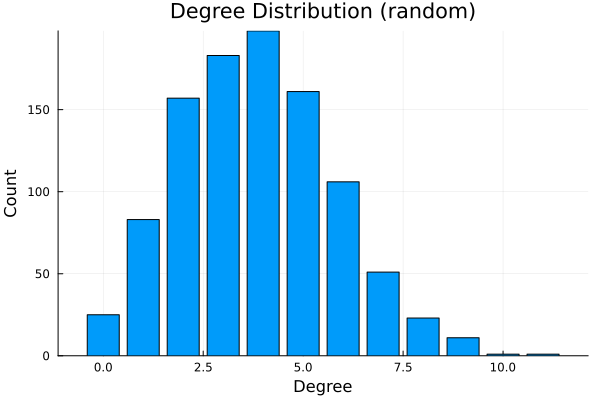

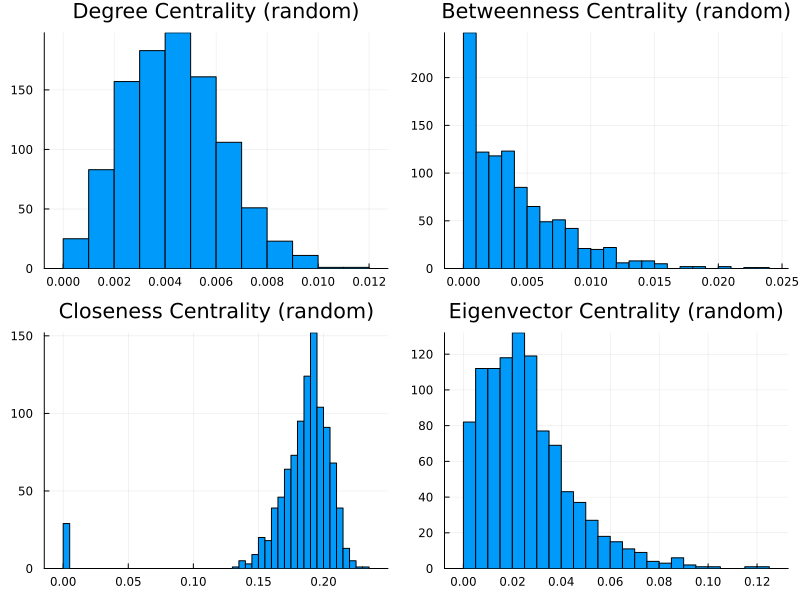

In [11]:
include("src/plotting.jl")

# Plot the degree distribution using our stored degree distribution data
plotdegdist = plot_degree_distribution(graph_analysis["degree_distribution"]; network_type=model.network_type)
display(plotdegdist)
savefig(plotdegdist, "figures/plotdegdist_$(model.network_type)_mdeg_$(model.mean_degree).pdf")

# Plot centrality distribution
p1 = histogram(graph_analysis["centrality"].degree_centrality, title="Degree Centrality ($(model.network_type))", legend=false)
p2 = histogram(graph_analysis["centrality"].betweenness_centrality, title="Betweenness Centrality ($(model.network_type))", legend=false)
p3 = histogram(graph_analysis["centrality"].closeness_centrality, title="Closeness Centrality ($(model.network_type))", legend=false)
p4 = histogram(graph_analysis["centrality"].eigenvector_centrality, title="Eigenvector Centrality ($(model.network_type))", legend=false)

centrality_plot = plot(p1, p2, p3, p4, layout=(2,2), size=(800, 600))
display(centrality_plot)

### SIR Dynamics on the Random Network

To simulate the SIR dynamics, we will use the `run!` function. This function takes the model and the number of days to simulate as arguments. The simulation will run for a specified number of days, updating the status of each agent based on their interactions with their neighbors.

We specify which data to collect during the simulation by defining:

- **`adata`**: Data to collect for each agent (e.g., infection status).
- **`mdata`**: Data to collect for the model (e.g., counts of susceptible, infected, and recovered agents).

The results are stored in the DataFrames `adf` and `mdf`, respectively.

In [8]:
# specify "adata" (agent data to collect) and "mdata" (model data to collect)
adata = [:status]
mdata = [:susceptible_count, :infected_count, :recovered_count]

adf, mdf = run!(model, 100; adata, mdata);

### Epidemic Trajectory Visualization

Now we can visualize the results of our simulation. The plot below shows the epidemic trajectories over time:

- The number of **susceptible** individuals (decreasing as the infection spreads)
- The number of **infected** individuals (rising and then falling as people recover)
- The number of **recovered** individuals (increasing as infected people recover)

The filename of the saved plot includes all the key parameters of our simulation:
- Network type (random, smallworld, etc.)
- Mean degree (average number of connections per node)
- Number of nodes in the network
- Dispersion parameter (for negative binomial degree distributions)
- Patient zero selection method
- Risk parameters (high risk activation and fraction)
- Transmission probability

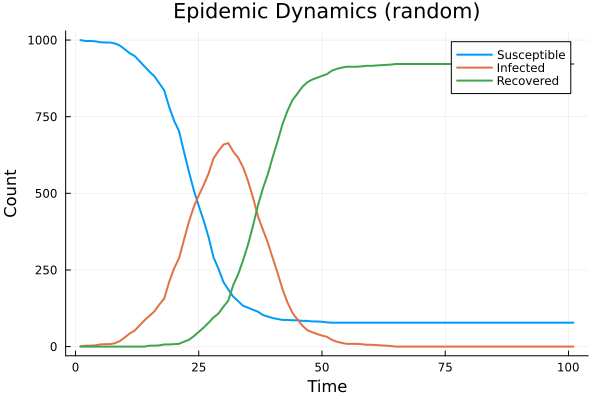

In [13]:
plotdynamics = plot_epidemic_trajectories(mdf, model.network_type)
display(plotdynamics)
savefig(plotdynamics, "figures/plotdynamics_$(model.network_type)_mdeg_$(model.mean_degree)_nn_$(model.n_nodes)_disp_$(model.dispersion)_pat0_$(model.patient_zero)_hirisk_$(model.high_risk)_hr_frac_$(model.fraction_high_risk)_trans_$(model.trans_prob).pdf");

## Single Run Visualization

Let's run a single simulation and inspect both the epidemic dynamics plot and the degree distribution plot. The `plot_single_run` function returns both plots and a combined plot, making it easy to examine them together.

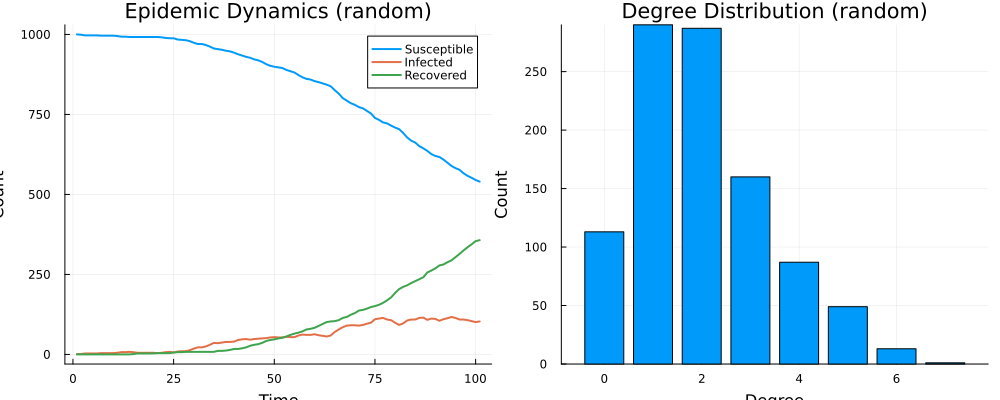

In [10]:
# Get both plots from plot_single_run
dynamics_plot, degdist_plot, combined_plot = plot_single_run(; network_type=:random, mean_degree=2)

display(combined_plot)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06Progress:  36%|███████████████                          |  ETA: 0:00:05Progress:  36%|███████████████                          |  ETA: 0:00:05Progress:  63%|██████████████████████████               |  ETA: 0:00:02Progress:  63%|██████████████████████████               |  ETA: 0:00:02Progress:  91%|██████████████████████████████████████   |  ETA: 0:00:01Progress:  91%|██████████████████████████████████████   |  ETA: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


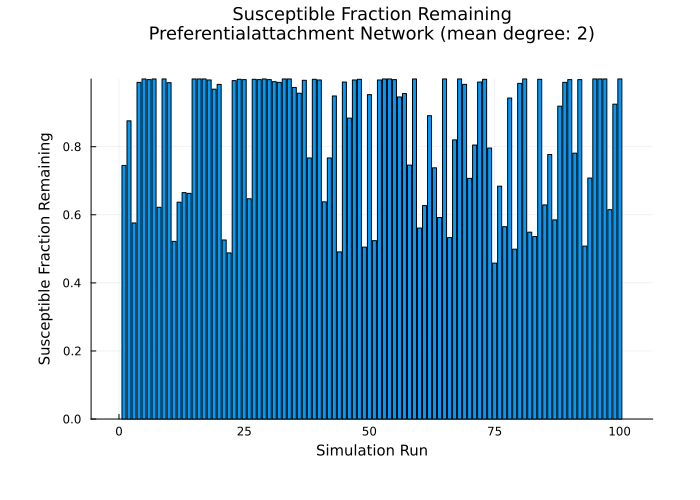

In [ ]:
include("src/run_simulations.jl")
# Run the simulation multiple times with different seeds (100 times), output results to file and plot
result_plot = run_and_plot(; plot_type=:sfr, network_type=:preferentialattachment, patient_zero=:maxdegree, mean_degree=4)
display(result_plot)